# Optimization with Genetic Algorithms

## Load TSP problem + display basic info

In [2]:
import tsplib95
import networkx as nx

# load TSP problem 
problem = tsplib95.load_problem('./att48.tsp') 

# display basic info
problem_name = problem.name
num_nodes = problem.dimension
edge_weight_type = problem.edge_weight_type

print("Problem Name:", problem_name)
print("Number of Nodes:", num_nodes)
print("Edge Weight Type:", edge_weight_type)


Problem Name: att48
Number of Nodes: 48
Edge Weight Type: ATT


/var/folders/v4/0f9n6lpx3pn7ghtrplsk92h80000gn/T/ipykernel_76235/4255359353.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem('./att48.tsp')


## Genetic Algorithm Framework

### Chromosome Representation

In [3]:
import random

def create_chromosome(cities):
    """
    Create a chromosome - random permutation of the cities.

    :param cities: is list of cities (or nodes).
    :return: the list representing a random perm of the cities.
    """
    chromosome = cities.copy()
    random.shuffle(chromosome)
    return chromosome

# gets the list of cities from the TSP problem
cities = list(problem.get_nodes())

# creates a chromosome
chromosome = create_chromosome(cities)

print("Chromosome (Tour):", chromosome)


Chromosome (Tour): [4, 13, 7, 40, 48, 39, 6, 43, 12, 8, 1, 21, 15, 35, 9, 16, 25, 33, 37, 29, 23, 20, 19, 5, 27, 34, 42, 2, 28, 17, 32, 26, 36, 38, 31, 18, 47, 44, 3, 24, 30, 11, 22, 46, 14, 10, 41, 45]


### Fitness Function

In [4]:
def calculate_total_distance(chromosome, problem):
    """
    It sums the total distance of the tour represented by the chromosome.

    :param chromosome: is a list representing the tour (perm of cities).
    :param problem: the TSP problem instance from TSPLIB library.
    :return: total distance
    """
    total_distance = 0
    num_cities = len(chromosome)

    for i in range(num_cities):
        # get current city and next city
        current_city = chromosome[i]
        next_city = chromosome[(i + 1) % num_cities]

        # distance between currenct city and next city
        total_distance += problem.get_weight(current_city, next_city)

    return total_distance

# example
chromosome = create_chromosome(cities) # function to create chromosome (from section above)
fitness = calculate_total_distance(chromosome, problem)

print("Total distance of the tour:", fitness)


Total distance of the tour: 56535


## Genetic Operators

### Selection

They are also available with external tools like deep

In [5]:
import random

def roulette_wheel_selection(population, fitnesses):
    """
    Perform roulette wheel selection.

    :param population: A list of chromosomes (individuals).
    :param fitnesses: A list of fitness values corresponding to the chromosomes.
    :return: Selected chromosome.
    """
    total_fitness = sum(fitnesses)
    pick = random.uniform(0, total_fitness)
    current = 0
    for chromosome, fitness in zip(population, fitnesses):
        current += fitness
        if current > pick:
            return chromosome


In [6]:
def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Perform tournament selection.

    :param population: A list of chromosomes (individuals).
    :param fitnesses: A list of fitness values corresponding to the chromosomes.
    :param tournament_size: Number of individuals in each tournament.
    :return: Selected chromosome.
    """
    # random selection of tournament_size indiv
    tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
    
    # besst indiv from the tournament
    best_individual = max(tournament, key=lambda x: x[1])[0]
    return best_individual


### Crossover

In [7]:
def ordered_crossover(parent1, parent2):
    """
    Perform ordered crossover between two parents.

    :param parent1: The first parent chromosome (a tour).
    :param parent2: The second parent chromosome (a tour).
    :return: Two offspring chromosomes.
    """
    size = len(parent1)
    child1, child2 = [-1] * size, [-1] * size

    # select a crossover point range
    start, end = sorted(random.sample(range(size), 2))

    # copy from first parent to first child
    child1[start:end] = parent1[start:end]

    # fill remaining with genes for second parent
    p2_index = 0
    for i in range(size):
        if child1[i] == -1:
            while parent2[p2_index] in child1:
                p2_index += 1
            child1[i] = parent2[p2_index]

    # same process for 2nd child
    child2[start:end] = parent2[start:end]
    p1_index = 0
    for i in range(size):
        if child2[i] == -1:
            while parent1[p1_index] in child2:
                p1_index += 1
            child2[i] = parent1[p1_index]

    return child1, child2


### Mutation

In [8]:
def swap_mutation(chromosome):
    """
    Perform swap mutation on a chromosome.

    :param chromosome: A chromosome (a tour).
    :return: A mutated chromosome.
    """
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome


In [9]:
def scramble_mutation(chromosome):
    """
    Perform scramble mutation on a chromosome.

    :param chromosome: A chromosome (a tour).
    :return: A mutated chromosome.
    """
    start, end = sorted(random.sample(range(len(chromosome)), 2))
    chromosome_to_scramble = chromosome[start:end]
    random.shuffle(chromosome_to_scramble)
    chromosome[start:end] = chromosome_to_scramble
    return chromosome


## Algorithm Initialization

### Population Initialization

In [10]:
def initialize_population(num_individuals, cities):
    """
    Initialize a population for the TSP.

    :param num_individuals: The number of individuals in the population.
    :param cities: A list of cities (nodes).
    :return: A list of chromosomes, where each chromosome is a random tour.
    """
    return [create_chromosome(cities) for _ in range(num_individuals)]

# example
num_individuals = 50  # For example, a population of 50 individuals
population = initialize_population(num_individuals, cities)

# display
print("First few individuals in the population:")
for i in range(min(5, num_individuals)):
    print(population[i])


First few individuals in the population:
[41, 3, 21, 45, 16, 12, 13, 2, 27, 37, 38, 47, 1, 33, 30, 48, 46, 6, 17, 19, 36, 15, 18, 20, 40, 24, 5, 26, 10, 11, 42, 31, 34, 23, 4, 22, 8, 44, 29, 9, 35, 14, 39, 32, 25, 43, 28, 7]
[31, 4, 11, 26, 7, 47, 14, 20, 35, 1, 25, 29, 17, 41, 28, 12, 34, 43, 24, 44, 22, 32, 16, 39, 33, 3, 45, 30, 10, 21, 27, 36, 18, 48, 40, 38, 15, 42, 23, 19, 9, 6, 13, 5, 46, 2, 37, 8]
[39, 43, 44, 25, 26, 2, 23, 8, 42, 7, 5, 40, 21, 22, 20, 24, 29, 38, 30, 34, 9, 47, 32, 6, 15, 4, 27, 3, 17, 31, 16, 28, 41, 1, 45, 14, 48, 46, 18, 35, 12, 19, 13, 33, 10, 36, 37, 11]
[10, 8, 25, 39, 24, 30, 6, 1, 34, 5, 17, 9, 2, 48, 41, 22, 14, 40, 15, 28, 26, 36, 16, 47, 20, 4, 33, 29, 35, 38, 13, 44, 19, 32, 45, 42, 23, 18, 21, 3, 31, 46, 43, 11, 12, 27, 7, 37]
[28, 43, 15, 32, 19, 34, 14, 9, 44, 18, 40, 16, 1, 29, 47, 23, 48, 8, 2, 37, 36, 5, 27, 7, 10, 22, 4, 24, 6, 20, 42, 30, 38, 21, 26, 45, 41, 46, 33, 3, 13, 35, 17, 31, 11, 39, 12, 25]


### Parameters Setup

In [11]:
# Genetic Algorithm param


# reason: a larger population can explore the search space more thoroughly but increases computational cost(100 is still ok).
population_size = 100


# reason: higher rates increase the genetic diversity of the population, but too high a rate can deny good solutions.
crossover_rate = 0.8

# reason: needed to introduce new genetic material into the population, but should be low to avoid random search.
mutation_rate = 0.05

# reason: more generations allow more time for the algorithm to improve solutions, but also increase computational time.
num_generations = 500

# reason: 'roulette' mimics natural selection, while 'tournament' can maintain diversity. Choice depends on problem specifics.
selection_method = 'tournament'

# Larger tournaments are more competitive, leading to stronger selection pressure.
tournament_size = 5

# Print the parameters
print("Population Size:", population_size)
print("Crossover Rate:", crossover_rate)
print("Mutation Rate:", mutation_rate)
print("Number of Generations:", num_generations)
print("Selection Method:", selection_method)
print("Tournament Size (if using tournament selection):", tournament_size)


Population Size: 100
Crossover Rate: 0.8
Mutation Rate: 0.05
Number of Generations: 500
Selection Method: tournament
Tournament Size (if using tournament selection): 5


## Main Loop of the Genetic Algorithm

In [13]:
# Main Loop of the Genetic Algorithm

def genetic_algorithm_main_loop(problem, population_size, num_generations, crossover_rate, mutation_rate, selection_method, tournament_size):
#initialize population
    population = initialize_population(population_size, cities)

    # track the best solution found so far
    best_solution = None
    best_distance = float('inf')

    for generation in range(num_generations):
        # evaluate fitness of the current population
        fitnesses = [calculate_total_distance(individual, problem) for individual in population]

        # to update the best solution found so far
        for individual, distance in zip(population, fitnesses):
            if distance < best_distance:
                best_solution = individual
                best_distance = distance

        new_population = []
        while len(new_population) < population_size:
            # SELECTION
            if selection_method == 'tournament':
                parent1 = tournament_selection(population, fitnesses, tournament_size)
                parent2 = tournament_selection(population, fitnesses, tournament_size)
            # to be added more methods.....

            # CROSSOVER
            if random.random() < crossover_rate:
                child1, child2 = ordered_crossover(parent1, parent2)
            else:
                child1, child2 = parent1, parent2

            # MUTATION
            if random.random() < mutation_rate:
                child1 = swap_mutation(child1)
                child2 = swap_mutation(child2)

            #  new offspring to the new population
            new_population.extend([child1, child2])

        # Update the population for the next generation
        population = new_population[:population_size]

        # display the best distance found in this generation
        print(f"Generation {generation}: Best distance = {best_distance}")

    return best_solution, best_distance

# to run the genetic algorithm with my parameters
best_solution, best_distance = genetic_algorithm_main_loop(
    problem, 
    population_size, 
    num_generations, 
    crossover_rate, 
    mutation_rate, 
    selection_method, 
    tournament_size
)

print("Best Solution:", best_solution)
print("Best Distance:", best_distance)


Generation 0: Best distance = 39745
Generation 1: Best distance = 39745
Generation 2: Best distance = 39745
Generation 3: Best distance = 39745
Generation 4: Best distance = 39745
Generation 5: Best distance = 39745
Generation 6: Best distance = 39745
Generation 7: Best distance = 39745
Generation 8: Best distance = 39745
Generation 9: Best distance = 39745
Generation 10: Best distance = 39745
Generation 11: Best distance = 39745
Generation 12: Best distance = 39745
Generation 13: Best distance = 39745
Generation 14: Best distance = 39745
Generation 15: Best distance = 39745
Generation 16: Best distance = 39745
Generation 17: Best distance = 39745
Generation 18: Best distance = 39745
Generation 19: Best distance = 39745
Generation 20: Best distance = 39745
Generation 21: Best distance = 39745
Generation 22: Best distance = 39745
Generation 23: Best distance = 39745
Generation 24: Best distance = 39745
Generation 25: Best distance = 39745
Generation 26: Best distance = 39745
Generation 

## Experimentation with Parameters

In [14]:
# to define different sets of parameters for experimentation
parameter_sets = [
    {"population_size": 50, "crossover_rate": 0.7, "mutation_rate": 0.02, "selection_method": "tournament", "tournament_size": 3},
    {"population_size": 100, "crossover_rate": 0.9, "mutation_rate": 0.05, "selection_method": "tournament", "tournament_size": 5},
    # Add more parameter sets for experimentation in the future
    # ...
]

# the function to run the genetic algorithm with the given parameters
def run_genetic_algorithm_with_params(problem, params):
    return genetic_algorithm_main_loop(
        problem, 
        params["population_size"], 
        num_generations, 
        params["crossover_rate"], 
        params["mutation_rate"], 
        params["selection_method"], 
        params["tournament_size"]
    )

# running the algorithm with each parameter set and recording results
results = []
for i, params in enumerate(parameter_sets):
    print(f"Running GA with parameter set {i + 1}: {params}")
    best_solution, best_distance = run_genetic_algorithm_with_params(problem, params)
    results.append((params, best_solution, best_distance))
    print(f"Best solution for set {i + 1}: {best_solution}")
    print(f"Best distance for set {i + 1}: {best_distance}\n")



Running GA with parameter set 1: {'population_size': 50, 'crossover_rate': 0.7, 'mutation_rate': 0.02, 'selection_method': 'tournament', 'tournament_size': 3}
Generation 0: Best distance = 40380
Generation 1: Best distance = 40380
Generation 2: Best distance = 40380
Generation 3: Best distance = 40380
Generation 4: Best distance = 40380
Generation 5: Best distance = 40380
Generation 6: Best distance = 40380
Generation 7: Best distance = 40380
Generation 8: Best distance = 40380
Generation 9: Best distance = 40380
Generation 10: Best distance = 40380
Generation 11: Best distance = 40380
Generation 12: Best distance = 40380
Generation 13: Best distance = 40380
Generation 14: Best distance = 40380
Generation 15: Best distance = 40380
Generation 16: Best distance = 40380
Generation 17: Best distance = 40380
Generation 18: Best distance = 40380
Generation 19: Best distance = 40380
Generation 20: Best distance = 40380
Generation 21: Best distance = 40380
Generation 22: Best distance = 40380


## Results and Analysis

### Display the Best Solution

In [15]:
print("Best Tour:", best_solution)
print("Total Distance of the Best Tour:", best_distance)

Best Tour: [31, 47, 10, 4, 14, 5, 6, 1, 30, 43, 37, 29, 19, 17, 33, 28, 40, 22, 7, 34, 41, 16, 42, 21, 48, 23, 9, 13, 35, 3, 32, 26, 11, 8, 39, 25, 20, 46, 2, 24, 45, 18, 44, 27, 36, 12, 38, 15]
Total Distance of the Best Tour: 40824


### Performance Analysis (Plotting Fitness Over Generations)

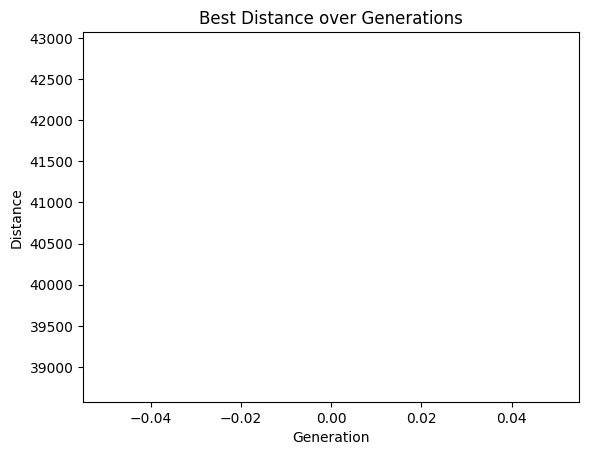

In [17]:
# list to store the best distance in each generation
best_distances_per_generation = []

# inside the genetic algorithm's main loop, after updating best_distance:
best_distances_per_generation.append(best_distance)

import matplotlib.pyplot as plt

plt.plot(best_distances_per_generation)
plt.title('Best Distance over Generations')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.show()


### Parameter Tuning Analysis

Parameter Set 1: {'population_size': 50, 'crossover_rate': 0.7, 'mutation_rate': 0.02, 'selection_method': 'tournament', 'tournament_size': 3}
Best Distance: 40380

Parameter Set 2: {'population_size': 100, 'crossover_rate': 0.9, 'mutation_rate': 0.05, 'selection_method': 'tournament', 'tournament_size': 5}
Best Distance: 40824



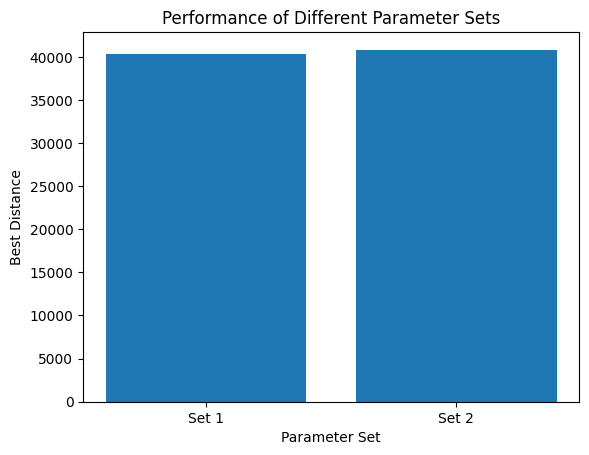

In [18]:
# list of results from different parameter sets
for i, (params, _, best_distance) in enumerate(results):
    print(f"Parameter Set {i + 1}: {params}")
    print(f"Best Distance: {best_distance}\n")

# plot the best distances for each parameter set for a visual comparison
best_distances = [best_distance for _, _, best_distance in results]
plt.bar(range(len(results)), best_distances, tick_label=[f"Set {i+1}" for i in range(len(results))])
plt.title('Performance of Different Parameter Sets')
plt.xlabel('Parameter Set')
plt.ylabel('Best Distance')
plt.show()
